## Preliminary
Point of this notebook is to get familiar with provided data and introduce prototype/reference solution based on simple data analysis to make getting into more sophisticated approaches easier.

Data set consist of 726 (720 train and 6 test) videos containing 242 plays taken from american football games (each play has been shot from 3 different views: Sideline, Endzone, All29). Beside that, 8 CSV files with additional information were provided. They contain data from sensors, helmet detection algorithm, required metadata needed for synchronising data with video frames. 

Details can be found at: https://www.kaggle.com/competitions/nfl-player-contact-detection/data?select=train

#### Splits out contact_id from sample_submission into seperate columns.

In [1]:
def expand_contact_id(df):
    df["game_play"] = df["contact_id"].str[:12]
    df["step"] = df["contact_id"].str.split("_").str[-3].astype("int")
    df["nfl_player_id_1"] = df["contact_id"].str.split("_").str[-2]
    df["nfl_player_id_2"] = df["contact_id"].str.split("_").str[-1]
    return df

#### Define paths to directories and read attatched CSVs:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from sklearn.metrics import matthews_corrcoef

# Read in data files
DATA_DIR = "../data"
OUTPUT_DIR = "../output_files/preliminary/"

ss = pd.read_csv(f"{DATA_DIR}/sample_submission.csv")
ss = expand_contact_id(ss)

# Labels and sample submission
tr_labels = pd.read_csv(f"{DATA_DIR}/train_labels.csv", parse_dates=["datetime"])
te_game_plays = ss.game_play.unique()
te_labels = tr_labels[tr_labels.game_play.isin(te_game_plays)]

# Player tracking data
tr_tracking = pd.read_csv(
    f"{DATA_DIR}/train_player_tracking.csv", parse_dates=["datetime"]
)
te_tracking = pd.read_csv(
    f"{DATA_DIR}/test_player_tracking.csv", parse_dates=["datetime"]
)

# Baseline helmet detection labels
tr_helmets = pd.read_csv(f"{DATA_DIR}/train_baseline_helmets.csv")
te_helmets = pd.read_csv(f"{DATA_DIR}/test_baseline_helmets.csv")

# Train video metadata with start/stop timestamps
tr_video_metadata = pd.read_csv(
    f"{DATA_DIR}/train_video_metadata.csv",
    parse_dates=["start_time", "end_time", "snap_time"],
)
# Test video metadata with start/stop timestamps
te_video_metadata = pd.read_csv(
    f"{DATA_DIR}/test_video_metadata.csv",
    parse_dates=["start_time", "end_time", "snap_time"],
)

In [3]:
tr_tracking.head()

,game_play,game_key,play_id,nfl_player_id,datetime,step,team,position,jersey_number,x_position,y_position,speed,distance,direction,orientation,acceleration,sa
0,58580_001136,58580,1136,44830,2021-10-10 21:08:20.900000+00:00,-108,away,CB,22,61.59,42.60,1.11,0.11,320.33,263.93,0.71,-0.64
1,58580_001136,58580,1136,47800,2021-10-10 21:08:20.900000+00:00,-108,away,DE,97,59.48,26.81,0.23,0.01,346.84,247.16,1.29,0.90
2,58580_001136,58580,1136,52444,2021-10-10 21:08:20.900000+00:00,-108,away,FS,29,72.19,31.46,0.61,0.06,11.77,247.69,0.63,-0.33
3,58580_001136,58580,1136,46206,2021-10-10 21:08:20.900000+00:00,-108,home,TE,86,57.37,22.12,0.37,0.04,127.85,63.63,0.69,0.62
4,58580_001136,58580,1136,52663,2021-10-10 21:08:20.900000+00:00,-108,away,ILB,48,63.25,27.50,0.51,0.05,183.62,253.71,0.31,0.31


In [4]:
tr_labels.head()

,contact_id,game_play,datetime,step,nfl_player_id_1,nfl_player_id_2,contact
0,58168_003392_0_38590_43854,58168_003392,2020-09-11 03:01:48.100000+00:00,0,38590,43854,0
1,58168_003392_0_38590_41257,58168_003392,2020-09-11 03:01:48.100000+00:00,0,38590,41257,0
2,58168_003392_0_38590_41944,58168_003392,2020-09-11 03:01:48.100000+00:00,0,38590,41944,0
3,58168_003392_0_38590_42386,58168_003392,2020-09-11 03:01:48.100000+00:00,0,38590,42386,0
4,58168_003392_0_38590_47944,58168_003392,2020-09-11 03:01:48.100000+00:00,0,38590,47944,0


In [5]:
tr_helmets.head()

,game_play,game_key,play_id,view,video,frame,nfl_player_id,player_label,left,width,top,height
0,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,39947,H72,946,25,293,34
1,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,37211,H42,151,25,267,33
2,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,38590,H70,810,25,293,35
3,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,44822,H15,681,26,254,33
4,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,41944,V92,680,23,303,33


In [6]:
tr_video_metadata.head()

,game_play,game_key,play_id,view,start_time,end_time,snap_time
0,58168_003392,58168,3392,Endzone,2020-09-11 03:01:43.134000+00:00,2020-09-11 03:01:54.971000+00:00,2020-09-11 03:01:48.134000+00:00
1,58168_003392,58168,3392,Sideline,2020-09-11 03:01:43.134000+00:00,2020-09-11 03:01:54.971000+00:00,2020-09-11 03:01:48.134000+00:00
2,58172_003247,58172,3247,Endzone,2020-09-13 19:30:42.414000+00:00,2020-09-13 19:31:00.524000+00:00,2020-09-13 19:30:47.414000+00:00
3,58172_003247,58172,3247,Sideline,2020-09-13 19:30:42.414000+00:00,2020-09-13 19:31:00.524000+00:00,2020-09-13 19:30:47.414000+00:00
4,58173_003606,58173,3606,Endzone,2020-09-13 19:45:07.527000+00:00,2020-09-13 19:45:26.438000+00:00,2020-09-13 19:45:12.527000+00:00


#### To get better understanding of helmets data, function was written to add helmets bounding boxes to video frames.

Parameters:
- video_path - path to video of the play
- baseline_boxes - pd.dataframe with data from baseline_helmets.csv
- save_path - output path to which labeled video should be written

In [7]:
import os
import cv2
import subprocess
from IPython.display import Video, display
import pandas as pd


def video_with_helmets(
    video_path: str, baseline_boxes: pd.DataFrame, save_path: str, verbose=True
) -> str:
    """
    Annotates a video with baseline model boxes and labels.
    """
    VIDEO_CODEC = "MP4V"
    HELMET_COLOR = (0, 0, 0)  # Black
    video_name = os.path.basename(video_path)
    if verbose:
        print(f"Running for {video_name}")
    baseline_boxes = baseline_boxes.copy()

    vidcap = cv2.VideoCapture(video_path)
    fps = vidcap.get(cv2.CAP_PROP_FPS)
    width = int(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    output_video = cv2.VideoWriter(
        save_path, cv2.VideoWriter_fourcc(*VIDEO_CODEC), fps, (width, height)
    )

    frame = 0
    while True:
        it_worked, img = vidcap.read()
        if not it_worked:
            break
        # We need to add 1 to the frame count to match the label frame index
        # that starts at 1
        frame += 1

        # Let's add a frame index to the video so we can track where we are
        img_name = video_name.replace(".mp4", "")
        cv2.putText(
            img,
            img_name,
            (10, 30),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            HELMET_COLOR,
            thickness=1,
        )

        cv2.putText(
            img,
            str(frame),
            (1280 - 90, 720 - 20),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            HELMET_COLOR,
            thickness=1,
        )

        # Now, add the boxes
        boxes = baseline_boxes.query("video == @video_name and frame == @frame")
        for box in boxes.itertuples(index=False):
            cv2.rectangle(
                img,
                (box.left, box.top),
                (box.left + box.width, box.top + box.height),
                HELMET_COLOR,
                thickness=1,
            )
            cv2.putText(
                img,
                box.player_label,
                (box.left + 1, max(0, box.top - 20)),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                HELMET_COLOR,
                thickness=1,
            )

        output_video.write(img)
    output_video.release()

    return save_path

#### Test on example play from train set (game_play id 58168_003392)

In [8]:
example_video = f"{DATA_DIR}/train/58168_003392_Sideline.mp4"
save_path = f"{OUTPUT_DIR}/labeled_58168_003392_Sideline.mp4"
output_video = video_with_helmets(example_video, tr_helmets, save_path)

frac = 0.65  # scaling factor for display
# display(
#     Video(data=output_video, embed=False, height=int(720 * frac), width=int(1280 * frac))
# )

Running for 58168_003392_Sideline.mp4


#### Create matplotlib plot with football pitch to apply players position to it

In [9]:
import matplotlib.patches as patches
import matplotlib.pylab as plt

def create_football_field(
    linenumbers=True,
    endzones=True,
    figsize=(12, 6.33),
    line_color="black",
    field_color="white",
    ez_color=None,
    ax=None,
    return_fig=False,
):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """

    if ez_color is None:
        ez_color = field_color

    rect = patches.Rectangle(
        (0, 0),
        120,
        53.3,
        linewidth=0.1,
        edgecolor="r",
        facecolor=field_color,
        zorder=0,
    )

    if ax is None:
        fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)
    ax.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color=line_color)
    
    # Endzones
    if endzones:
        ez1 = patches.Rectangle(
            (0, 0),
            10,
            53.3,
            linewidth=0.1,
            edgecolor=line_color,
            facecolor=ez_color,
            alpha=0.6,
            zorder=0,
        )
        ez2 = patches.Rectangle(
            (110, 0),
            10,
            53.3,
            linewidth=0.1,
            edgecolor=line_color,
            facecolor=ez_color,
            alpha=0.6,
            zorder=0,
        )
        ax.add_patch(ez1)
        ax.add_patch(ez2)

    ax.axis("off")
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            ax.text(
                x,
                5,
                str(numb - 10),
                horizontalalignment="center",
                fontsize=20,  # fontname='Arial',
                color=line_color,
            )
            ax.text(
                x - 0.95,
                53.3 - 5,
                str(numb - 10),
                horizontalalignment="center",
                fontsize=20,  # fontname='Arial',
                color=line_color,
                rotation=180,
            )
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)

    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color=line_color)
        ax.plot([x, x], [53.0, 52.5], color=line_color)
        ax.plot([x, x], [22.91, 23.57], color=line_color)
        ax.plot([x, x], [29.73, 30.39], color=line_color)

    border = patches.Rectangle(
        (-5, -5),
        120 + 10,
        53.3 + 10,
        linewidth=0.1,
        edgecolor="orange",
        facecolor=line_color,
        alpha=0,
        zorder=0,
    )
    ax.add_patch(border)
    ax.set_xlim((-5, 125))
    ax.set_ylim((-5, 53.3 + 5))

    if return_fig:
        return fig, ax
    else:
        return ax

#### Make visualization for example play with id 58168_003392 and step 0

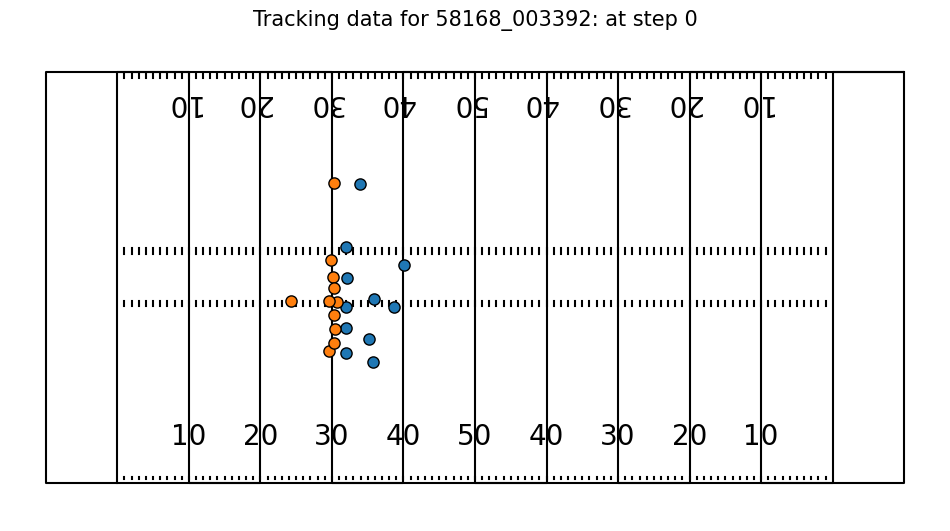

In [10]:
game_play = "58168_003392"
example_tracks = tr_tracking.query("game_play == @game_play and step == 0")
ax = create_football_field()
for team, d in example_tracks.groupby("team"):
    ax.scatter(
        d["x_position"],
        d["y_position"],
        label=team,
        s=65,
        lw=1,
        edgecolors="black",
        zorder=5,
    )
ax.legend().remove()
ax.set_title(f"Tracking data for {game_play}: at step 0", fontsize=15)
plt.show()

#### Synchronize data from baseline helmets with contact labels.
 
Helmets are indexed with frame number of the video taken with frequency 59.94 Hz and labels with datetime. To synchronize, metadata is required to tell on what time the video starts.

In [11]:
def join_helmets_contact(game_play, labels, helmets, meta, view="Sideline", fps=59.94):
    """
    Joins helmets and labels for a given game_play. Results can be used for visualizing labels.
    Returns a dataframe with the joint dataframe, duplicating rows if multiple contacts occur.
    """
    gp_labs = labels.query("game_play == @game_play").copy()
    gp_helms = helmets.query("game_play == @game_play").copy()

    start_time = meta.query("game_play == @game_play and view == @view")[
        "start_time"
    ].values[0]

    gp_helms["datetime"] = (
        pd.to_timedelta(gp_helms["frame"] * (1 / fps), unit="s") + start_time
    )
    gp_helms["datetime"] = pd.to_datetime(gp_helms["datetime"], utc=True)
    gp_helms["datetime_ngs"] = (
        pd.DatetimeIndex(gp_helms["datetime"] + pd.to_timedelta(50, "ms"))
        .floor("100ms")
        .values
    )
    gp_helms["datetime_ngs"] = pd.to_datetime(gp_helms["datetime_ngs"], utc=True)

    gp_labs["datetime_ngs"] = pd.to_datetime(gp_labs["datetime"], utc=True)

    gp = gp_helms.merge(
        gp_labs.query("contact == 1")[
            ["datetime_ngs", "nfl_player_id_1", "nfl_player_id_2", "contact_id"]
        ],
        left_on=["datetime_ngs", "nfl_player_id"],
        right_on=["datetime_ngs", "nfl_player_id_1"],
        how="left",
    )
    return gp

#### Using merged by join_helmets dataframe, expand added bounding boxes, by adding colors on contact

In [12]:
import os
import cv2
import subprocess
from IPython.display import Video, display
import pandas as pd


def video_with_contact(
    video_path: str, baseline_boxes: pd.DataFrame, save_path: str, verbose=True
) -> str:
    """
    Annotates a video with baseline model boxes.
    Helmet boxes are colored based on the contact label.
    """
    VIDEO_CODEC = "MP4V"
    HELMET_COLOR = (0, 0, 0)  # Black
    video_name = os.path.basename(video_path)
    if verbose:
        print(f"Running for {video_name}")
    baseline_boxes = baseline_boxes.copy()

    vidcap = cv2.VideoCapture(video_path)
    fps = vidcap.get(cv2.CAP_PROP_FPS)
    width = int(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    output_video = cv2.VideoWriter(
        save_path, cv2.VideoWriter_fourcc(*VIDEO_CODEC), fps, (width, height)
    )
    frame = 0
    while True:
        it_worked, img = vidcap.read()
        if not it_worked:
            break
        # We need to add 1 to the frame count to match the label frame index
        # that starts at 1
        frame += 1

        # Let's add a frame index to the video so we can track where we are
        img_name = video_name.replace('.mp4','')
        cv2.putText(
            img,
            img_name,
            (10, 30),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            HELMET_COLOR,
            thickness=1,
        )
        
        cv2.putText(
            img,
            str(frame),
            (1280 - 90, 720 - 20),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            HELMET_COLOR,
            thickness=1,
        )

        # Now, add the boxes
        boxes = baseline_boxes.query("video == @video_name and frame == @frame")
        contact_players = boxes.dropna(subset=["nfl_player_id_2"]).query(
            'nfl_player_id_2 != "G"'
        )
        contact_ids = (
            contact_players["nfl_player_id_1"].astype("int").values.tolist()
            + contact_players["nfl_player_id_2"].astype("int").values.tolist()
        )
        for box in boxes.itertuples(index=False):

            if box.nfl_player_id_2 == "G":
                box_color = (0, 0, 255)  # Red
                box_thickness = 2
            elif int(box.nfl_player_id) in contact_ids:
                box_color = (0, 255, 0)  # green
                box_thickness = 2

                # Add line between players in contact
                if not np.isnan(float(box.nfl_player_id_2)):
                    player2 = int(box.nfl_player_id_2)
                    player2_row = boxes.query("nfl_player_id == @player2")
                    if len(player2_row) == 0:
                        # Player 2 is not in view
                        continue
                    cv2.line(
                        img,
                        (box.left + int(box.width / 2), box.top + int(box.height / 2)),
                        (
                            player2_row.left.values[0]
                            + int(player2_row.width.values[0] / 2),
                            player2_row.top.values[0]
                            + int(player2_row.height.values[0] / 2),
                        ),
                        color=(255, 0, 0),
                        thickness=2,
                    )

            else:
                box_color = HELMET_COLOR
                box_thickness = 1

            # Draw lines between two boxes

            cv2.rectangle(
                img,
                (box.left, box.top),
                (box.left + box.width, box.top + box.height),
                box_color,
                thickness=box_thickness,
            )
            cv2.putText(
                img,
                box.player_label,
                (box.left + 1, max(0, box.top - 20)),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                HELMET_COLOR,
                thickness=1,
            )

        output_video.write(img)
    output_video.release()


    return save_path

#### Test function for play 58168_003392 from test set

In [13]:
game_play = "58168_003392"
gp = join_helmets_contact(game_play, te_labels, te_helmets, te_video_metadata)

example_video = f"{DATA_DIR}/test/{game_play}_Sideline.mp4"
save_path = f"{OUTPUT_DIR}/contact_{game_play}_Sideline.mp4"
output_video = video_with_contact(example_video, gp, save_path)


Running for 58168_003392_Sideline.mp4


#### Merge tracking data and contact labels and add custom distance beteween two players column.

In [14]:
def compute_distance(df, tr_tracking, merge_col="datetime"):
    """
    Merges tracking data on player1 and 2 and computes the distance.
    """
    df_combo = (
        df.astype({"nfl_player_id_1": "str"})
        .merge(
            tr_tracking.astype({"nfl_player_id": "str"})[
                ["game_play", merge_col, "nfl_player_id", "x_position", "y_position"]
            ],
            left_on=["game_play", merge_col, "nfl_player_id_1"],
            right_on=["game_play", merge_col, "nfl_player_id"],
            how="left",
        )
        .rename(columns={"x_position": "x_position_1", "y_position": "y_position_1"})
        .drop("nfl_player_id", axis=1)
        .merge(
            tr_tracking.astype({"nfl_player_id": "str"})[
                ["game_play", merge_col, "nfl_player_id", "x_position", "y_position"]
            ],
            left_on=["game_play", merge_col, "nfl_player_id_2"],
            right_on=["game_play", merge_col, "nfl_player_id"],
            how="left",
        )
        .drop("nfl_player_id", axis=1)
        .rename(columns={"x_position": "x_position_2", "y_position": "y_position_2"})
        .copy()
    )

    df_combo["distance"] = np.sqrt(
        np.square(df_combo["x_position_1"] - df_combo["x_position_2"])
        + np.square(df_combo["y_position_1"] - df_combo["y_position_2"])
    )
    return df_combo



#### Merge, compute distance and fill NaN distances (contacts with ground) with big values

In [15]:
df_dist = compute_distance(tr_labels, tr_tracking)

print(df_dist.shape, tr_labels.shape)

df_dist["distance"] = df_dist["distance"].fillna(99)  # Fill player to ground with 99

(4721618, 12) (4721618, 7)


In [16]:
df_dist.head()

,contact_id,game_play,datetime,step,nfl_player_id_1,nfl_player_id_2,contact,x_position_1,y_position_1,x_position_2,y_position_2,distance
0,58168_003392_0_38590_43854,58168_003392,2020-09-11 03:01:48.100000+00:00,0,38590,43854,0,40.33,25.28,41.99,16.79,8.650763
1,58168_003392_0_38590_41257,58168_003392,2020-09-11 03:01:48.100000+00:00,0,38590,41257,0,40.33,25.28,45.77,15.59,11.112592
2,58168_003392_0_38590_41944,58168_003392,2020-09-11 03:01:48.100000+00:00,0,38590,41944,0,40.33,25.28,42.00,22.85,2.948525
3,58168_003392_0_38590_42386,58168_003392,2020-09-11 03:01:48.100000+00:00,0,38590,42386,0,40.33,25.28,45.87,23.89,5.711716
4,58168_003392_0_38590_47944,58168_003392,2020-09-11 03:01:48.100000+00:00,0,38590,47944,0,40.33,25.28,42.10,26.58,2.196110


#### Check which distance threshold is optimal for classifying contact by calculating correlation with GT labels

In [17]:
for dist in range(0, 5):
    score = matthews_corrcoef(df_dist["contact"], df_dist["distance"] <= dist)
    print(f"Threshold Distance: {dist} Yard - MCC Score: {score:0.4f}")

Threshold Distance: 0 Yard - MCC Score: 0.0000
Threshold Distance: 1 Yard - MCC Score: 0.5201
Threshold Distance: 2 Yard - MCC Score: 0.3592
Threshold Distance: 3 Yard - MCC Score: 0.2517
Threshold Distance: 4 Yard - MCC Score: 0.1935


#### Create submission with chosen threshold method

In [18]:
ss = pd.read_csv(f"{DATA_DIR}/sample_submission.csv")

THRES = 1

ss = expand_contact_id(ss)
ss_dist = compute_distance(ss, te_tracking, merge_col="step")

print(ss_dist.shape, ss.shape)

submission = ss_dist[["contact_id", "distance"]].copy()
submission["contact"] = (submission["distance"] <= THRES).astype("int")
submission = submission.drop('distance', axis=1)
submission[["contact_id", "contact"]].to_csv(f"{OUTPUT_DIR}/submission.csv", index=False)

submission.head()

(49588, 11) (49588, 6)


,contact_id,contact
0,58168_003392_0_38590_43854,0
1,58168_003392_0_38590_41257,0
2,58168_003392_0_38590_41944,0
3,58168_003392_0_38590_42386,0
4,58168_003392_0_38590_47944,0


#### View results on a test video

In [19]:
predict_labels = expand_contact_id(submission)
predict_labels["datetime"] = pd.merge(predict_labels, te_labels, on="contact_id", how="inner")["datetime"]
predict_labels.nfl_player_id_1 = predict_labels.nfl_player_id_1.astype(int)
predict_labels.dtypes

contact_id                      object
contact                          int32
game_play                       object
step                             int32
nfl_player_id_1                  int32
nfl_player_id_2                 object
datetime           datetime64[ns, UTC]
dtype: object

In [20]:
te_labels.dtypes

contact_id                      object
game_play                       object
datetime           datetime64[ns, UTC]
step                             int64
nfl_player_id_1                  int64
nfl_player_id_2                 object
contact                          int64
dtype: object

In [21]:

game_play = "58168_003392"
gp = join_helmets_contact(game_play, predict_labels, te_helmets, te_video_metadata)

save_path = f"{OUTPUT_DIR}/predict_{game_play}_Sideline.mp4"
output_video = video_with_contact(example_video, gp, save_path)

frac = 0.65  # scaling factor for display


Running for 58168_003392_Sideline.mp4
